# 对于多分类问题的评估
1. 混淆矩阵（Skewed Data）
    - 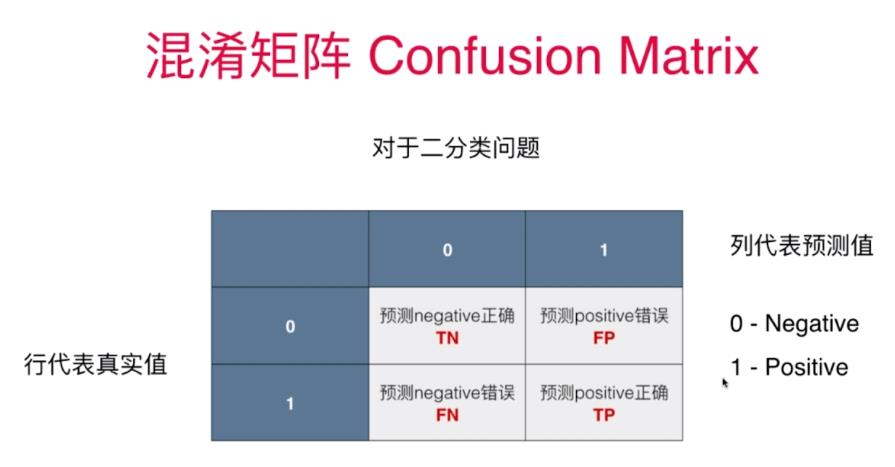
2. 精准率/查准率
    - 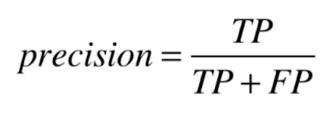
3. 召回率/查全率
    - 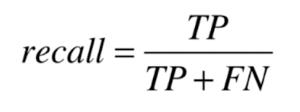
4. F-score
    - 兼顾精准率与召回率，是二者的调和平均值
    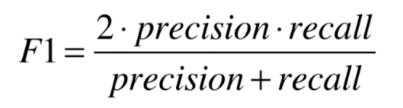
    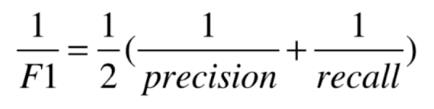
    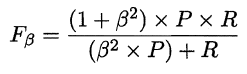
    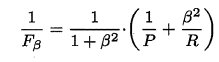
5. Precision-Recall曲线
    - 越外面的曲线所对应的模型越好
6. ROC曲线
    - 受试者工作特征曲线 （receiver operating characteristic curve），又称为感受性曲线（sensitivity curve）。得此名的原因在于曲线上各点反映着相同的感受性，它们都是对同一信号刺激的反应，只不过是在几种不同的判定标准下所得的结果而已。接受者操作特性曲线就是以假阳性概率（False positive rate）为横轴，击中概率为纵轴所组成的坐标图，和被试在特定刺激条件下由于采用不同的判断标准得出的不同结果画出的曲线。
    - ROC中的AUC（area under curve）越大，代表模型越好

# 简单实现混淆矩阵，精准率和召回率

In [5]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

digits = datasets.load_digits()
X = digits.data
y = digits.target.copy()  #获得原数据集的一份拷贝，避免影响原数据集
y[digits.target==9] = 1
y[digits.target!=9] = 0

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)

In [6]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

0.97555555555555551

In [7]:
y_log_predict = log_reg.predict(X_test)

### TN

In [8]:
def TN(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true==0) & (y_predict==0))

TN(y_test, y_log_predict)

403

### FP

In [9]:
def FP(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true==0) & (y_predict==1))

FP(y_test, y_log_predict)

2

### FN

In [10]:
def FN(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true==1) & (y_predict==0))

FN(y_test, y_log_predict)

9

### TP

In [11]:
def TP(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true==1) & (y_predict==1))

TP(y_test, y_log_predict)

36

### confusion_matrix

In [12]:
def confusion_matrix(y_true, y_predict):
    return np.array([
        [TN(y_true, y_predict), FP(y_true, y_predict)],
        [FN(y_true, y_predict), TP(y_true, y_predict)]
    ])

confusion_matrix(y_test, y_log_predict)

array([[403,   2],
       [  9,  36]])

### precision

In [13]:
def precision_score(y_true, y_predict):
    tp = TP(y_true, y_predict)
    fp = FP(y_true, y_predict)
    try:
        return tp / (tp + fp)
    except:
        return 0.0
    
precision_score(y_test, y_log_predict)

0.94736842105263153

### recall

In [14]:
def recall_score(y_true, y_predict):
    tp = TP(y_true, y_predict)
    fn = FN(y_true, y_predict)
    try:
        return tp / (tp + fn)
    except:
        return 0.0
    
recall_score(y_test, y_log_predict)

0.80000000000000004

### F1-score

In [15]:
def f1_score(precision, recall):
    try:
        return 2 * precision * recall / (precision + recall)
    except:
        return 0.0
    
f1_score(0.7, 0.7)

0.7

In [16]:
f1_score(0.9, 0.1)

0.18000000000000002

# sklearn中的混淆矩阵、精准率、召回率、F1值

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_log_predict)

array([[403,   2],
       [  9,  36]], dtype=int64)

In [18]:
from sklearn.metrics import precision_score

precision_score(y_test, y_log_predict)

0.94736842105263153

In [19]:
from sklearn.metrics import recall_score

recall_score(y_test, y_log_predict)

0.80000000000000004

In [20]:
from sklearn.metrics import f1_score

f1_score(y_test, y_log_predict)

0.86746987951807231

# 精准率和召回率的平衡

#### LogisticRegression.decision_function用于计算所有样本各自的信赖分数

In [35]:
decision_scores = log_reg.decision_function(X_test)  #默认的用于判断的threshold=0

In [27]:
np.min(decision_scores)

-85.68608522646575

In [28]:
np.max(decision_scores)

19.889585879902199

##### threshold=5

In [29]:
y_predict2 = np.array(decision_scores >= 5, dtype='int')

confusion_matrix(y_test, y_predict2)

array([[404,   1],
       [ 21,  24]], dtype=int64)

In [30]:
precision_score(y_test, y_predict2)

0.95999999999999996

In [31]:
recall_score(y_test, y_predict2)

0.53333333333333333

##### threshold=-5

In [32]:
y_predict3 = np.array(decision_scores >= -5, dtype='int')

confusion_matrix(y_test, y_predict3)

array([[390,  15],
       [  5,  40]], dtype=int64)

In [33]:
precision_score(y_test, y_predict3)

0.72727272727272729

In [34]:
recall_score(y_test, y_predict3)

0.88888888888888884

### 简单绘制Precision-Recall曲线

In [46]:
precisions = []
recalls = []
thresholds = np.arange(np.min(decision_scores), np.max(decision_scores), 0.1)

for threshold in thresholds:
    y_predict = np.array(decision_scores >= threshold, dtype='int')
    precisions.append(precision_score(y_test, y_predict))
    recalls.append(recall_score(y_test, y_predict))

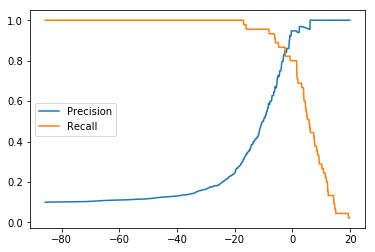

In [47]:
import matplotlib.pyplot as plt

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.legend()
plt.show()

### Precision-Recall曲线

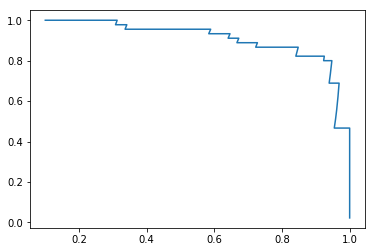

In [45]:
plt.plot(precisions, recalls)
plt.show()

# sklearn中的Precision_Recall_curve

In [48]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, decision_scores)

In [49]:
precisions.shape  #步长由函数自动设置

(145,)

In [50]:
recalls.shape

(145,)

In [51]:
thresholds.shape  #注意thresholds比上面两个量少1

(144,)

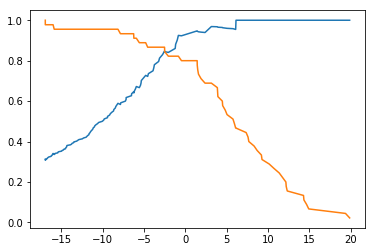

In [52]:
plt.plot(thresholds, precisions[:-1])  #因为少1，所以最后一个元素不取
plt.plot(thresholds, recalls[:-1])  #同上
plt.show()

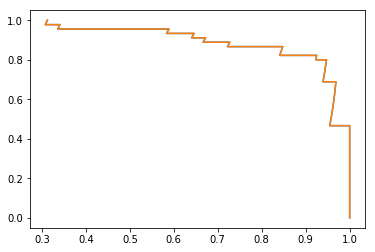

In [54]:
plt.plot(precisions, recalls)
plt.show()

# sklearn中的ROC曲线

In [55]:
from sklearn.metrics import roc_curve

fprs, tprs, thresholds = roc_curve(y_test, decision_scores)

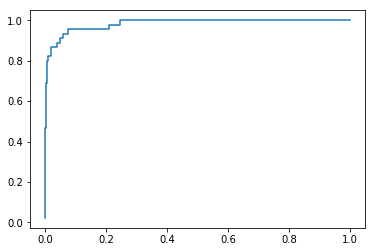

In [56]:
plt.plot(fprs, tprs)
plt.show()

### sklearn中的ROC曲线下面积（AUC）

In [57]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, decision_scores)#ROC曲线所包含的面积越大模型越好，对偏斜数据不敏感

0.98304526748971188

# sklearn中的多分类混淆矩阵

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

digits = datasets.load_digits()
X = digits.data
y = digits.target.copy()  #获得原数据集的一份拷贝，避免影响原数据集

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=666)

In [63]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

0.93115438108484005

In [66]:
y_predict = log_reg.predict(X_test)

### 使用参数average进行多分类求解

In [65]:
precision_score(y_test, y_predict, average='micro')

0.93115438108484005

### 多分类的混淆矩阵

In [67]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_predict)  #横向为真实值，纵向为预测值

array([[147,   0,   1,   0,   0,   1,   0,   0,   0,   0],
       [  0, 123,   1,   2,   0,   0,   0,   3,   4,  10],
       [  0,   0, 134,   1,   0,   0,   0,   0,   1,   0],
       [  0,   0,   0, 138,   0,   5,   0,   1,   5,   0],
       [  2,   5,   0,   0, 139,   0,   0,   3,   0,   1],
       [  1,   3,   1,   0,   0, 146,   0,   0,   1,   0],
       [  0,   2,   0,   0,   0,   1, 131,   0,   2,   0],
       [  0,   0,   0,   1,   0,   0,   0, 132,   1,   2],
       [  1,   9,   2,   3,   2,   4,   0,   0, 115,   4],
       [  0,   1,   0,   5,   0,   3,   0,   2,   2, 134]], dtype=int64)

##### 简单绘制混淆矩阵

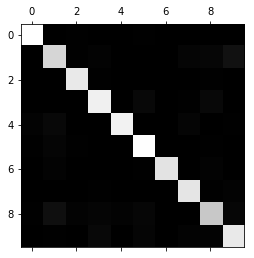

In [68]:
cfm = confusion_matrix(y_test, y_predict)
plt.matshow(cfm, cmap=plt.cm.gray)  #绘制矩阵图像
plt.show()  #越亮的块数值越大

In [69]:
row_sums = np.sum(cfm, axis=1)  #求每行的总和
err_matrix = cfm / row_sums  #计算每个元素占每行的百分比
np.fill_diagonal(err_matrix, 0)  #将err_matrix矩阵的对角线设置为全零
err_matrix

array([[ 0.        ,  0.        ,  0.00735294,  0.        ,  0.        ,
         0.00657895,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.00735294,  0.01342282,  0.        ,
         0.        ,  0.        ,  0.02205882,  0.02857143,  0.06802721],
       [ 0.        ,  0.        ,  0.        ,  0.00671141,  0.        ,
         0.        ,  0.        ,  0.        ,  0.00714286,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.03289474,  0.        ,  0.00735294,  0.03571429,  0.        ],
       [ 0.01342282,  0.03496503,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.02205882,  0.        ,  0.00680272],
       [ 0.00671141,  0.02097902,  0.00735294,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.00714286,  0.        ],
       [ 0.        ,  0.01398601,  0.        ,  0.        ,  0.        ,
         0.00657895,  0.        ,  0.        

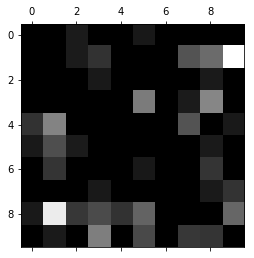

In [72]:
plt.matshow(err_matrix, cmap=plt.cm.gray)
plt.show()  #越亮代表犯的错误越多